In [1]:
import os
current_dir = %pwd
project_dir = os.path.dirname(current_dir)
%cd $project_dir

c:\Users\ayoub\OneDrive\Bureau\Datascientest_project\doc-classifier


c:\Users\ayoub\OneDrive\Bureau\Datascientest_project\doc-classifier\.venv\lib\site-packages\IPython\core\magics\osm.py:417: UserWarning: using dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [2]:
import json
import time
import copy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from joblib import load, dump
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV

from src import save_jsonfile, read_jsonfile

from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import NearestCentroid
from lightgbm.sklearn import LGBMClassifier
from xgboost.sklearn import XGBClassifier

C:\Users\ayoub\AppData\Local\Temp\ipykernel_60304\760780868.py:5: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


# Chargement des datasets train et test

In [3]:
df_train = pd.read_csv('data/processed/words_structure_train.csv')
df_test = pd.read_csv('data/processed/words_structure_test.csv')
seed = 42

In [4]:
df_train['words'] = df_train['words'].fillna('')
df_test['words'] = df_test['words'].fillna('')

X_train = df_train.drop('category', axis=1)
y_train = df_train['category']
X_test = df_test.drop('category', axis=1)
y_test = df_test['category']

### LabelEncoder

In [5]:
le = load("models/target_LabelEncoder.joblib")
y_train = le.transform(y_train)
y_test = le.transform(y_test)

### Standard Scaler

In [6]:
X_train_scaled = X_train.drop('words', axis=1)
X_test_scaled = X_test.drop('words', axis=1)

scaler = load('models/StandardScaler.joblib')
X_train_scaled = scaler.transform(X_train_scaled)
X_test_scaled = scaler.transform(X_test_scaled)

In [7]:
def calculate_accuracy(model, X_test: np.ndarray, y_test: np.ndarray) -> dict:
    cat_dict = {
        0: "email",
        1: "handwritten",
        2: "invoice",
        3: "national_identity_card",
        4: "passeport",
        5: "scientific_publication"
    }
    category_accuracies = {}
    y_pred = model.predict(X_test)
    category_accuracies['Global'] = accuracy_score(y_test, y_pred)

    categories = np.unique(y_test)
    for category in categories:
        mask = (y_test == category)
        category_accuracy = accuracy_score(y_test[mask], y_pred[mask])
        category_accuracies[cat_dict[category]] = category_accuracy

    return category_accuracies


def plot_search_results(cv_results: dict, best_params: dict, param_grid: dict, title: str) -> None:
    masks_names = [k for k, v in param_grid.items() if len(v) > 1]
    if not isinstance(cv_results, pd.DataFrame):
        cv_results = pd.DataFrame(cv_results)

    plot_results = {}
    for pk, pv in best_params.items():
        if pk not in masks_names:
            param_grid.pop(pk)
            continue
        plot_results[pk] = [[], [], []]
        for val in param_grid[pk]:
            if val != None:
                res_param = cv_results[cv_results[f'param_{pk}'] == val]
            else:
                res_param = cv_results.loc[cv_results[f'param_{pk}'].isnull()]

            id_ = res_param['mean_test_score'].idxmax()

            if pd.isna(id_):
                plot_results[pk][0].append(str(val))
                plot_results[pk][1].append(0.0)
                plot_results[pk][2].append(0.0)
            else:
                row = cv_results.iloc[id_]
                mean_test_score = row['mean_test_score']
                std_test_score = row['std_test_score']
                plot_results[pk][0].append(str(val))
                plot_results[pk][1].append(mean_test_score)
                plot_results[pk][2].append(std_test_score)

    ## Ploting results
    fig, ax = plt.subplots(1, len(plot_results), sharex='none', sharey='all', figsize=(20, 5))

    fig.suptitle(title+'\nScore per parameter')
    fig.text(0.04, 0.5, 'MEAN SCORE', va='center', rotation='vertical')
    for i, [name, values] in enumerate(plot_results.items()):
        x = np.array(values[0])
        y_1 = np.array(values[1])
        e_1 = np.array(values[2])
        ax[i].errorbar(x, y_1, e_1, linestyle='--', marker='o', label='test')
        ax[i].set_xlabel(name.upper())
    plt.legend()
    plt.show()

# Grille de Paramètres 

In [8]:
models_param_grids = {
    "LogisticRegression": {
        'penalty': ['l2'],
        'C': [0.01, 0.1, 1, 10, 100, 200],
        'solver': ['lbfgs'],
        'max_iter': [100, 200, 300, 400]
    },
    "LGBMClassifier": {
        'learning_rate': [0.1, 0.01],
        'n_estimators': [100, 200],
        'max_depth': [3, 5, 7],
        'subsample': [0.8, 0.9],
        'colsample_bytree': [0.8, 0.9, 1.0]
    },
    "RandomForestClassifier": {
        'n_estimators': [100, 200, 300],
        'max_depth': [None, 10, 20, 30],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    },
    "XGBClassifier": {
        'n_estimators': [100, 200],
        'max_depth': [3, 6],
        'learning_rate': [0.1, 0.2]
    },
    "ExtraTreesClassifier": {
        'n_estimators': [50, 100, 200, 300],
        'criterion': ['gini', 'entropy'],
        'max_depth': [None, 20, 30],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
        'max_features': ['sqrt', 'log2'],
        'bootstrap': [True],
        'oob_score': [True, False]
    },
    "NearestCentroid": {
        'metric': ['euclidean', 'manhattan'],
        'shrink_threshold': [None, 0.01, 10, 50]
    }
}

class Encoder(json.JSONEncoder):
    def default(self, obj):

        # Polygon or array convert to list
        if isinstance(obj, (np.ndarray)):
            return obj.tolist()

        # int32 convert to int
        if isinstance(obj, (np.int32)):
            return int(obj)

        return super().default(obj)


# Recherche d'hyper paramètres avec GridSearchCV

In [9]:


cv = 5
scoring = 'accuracy'
verbose = 3
n_jobs = -1

data_results = {}
output_data_name = 'models/words_scaled_GridSearchCV_result.json'
data_results['seed'] = seed
data_results['GridSearchCV_params'] = {'cv':cv, 'scoring':scoring, 'verbose':verbose, 'n_jobs':n_jobs}
for model_name, param_grid in models_param_grids.items():

    print('\n', "="*100, '\n')
    print("Train:", model_name)
    print("Params Grid:", param_grid)
    data_results[model_name] = {}
    data_results[model_name]['param_grid'] = param_grid

    if model_name == "LogisticRegression":
        model = LogisticRegression(random_state=seed)
    elif model_name == "NearestCentroid":
        model = NearestCentroid()
    elif model_name == "ExtraTreesClassifier":
        model = ExtraTreesClassifier(random_state=seed)
    elif model_name == "LGBMClassifier":
        model = LGBMClassifier(objective='multiclass', random_state=seed)
    elif model_name == "XGBClassifier":
        model = XGBClassifier(objective='multi:softprob', seed=seed)
    elif model_name == "RandomForestClassifier":
        model = RandomForestClassifier(random_state=seed)

    t0 = time.time()
    grid_search = GridSearchCV(model, param_grid, cv=cv, scoring=scoring, n_jobs=n_jobs, verbose=verbose)
    grid_search.fit(X_train_scaled, y_train)
    GridSearchCV_training_time = time.time() - t0
    print("GridSearchCV - DONE in", GridSearchCV_training_time/60, "min")
    data_results[model_name]['GridSearchCV_time'] = GridSearchCV_training_time
    data_results[model_name]['best_params'] = grid_search.best_params_
    data_results[model_name]['cv_results'] = grid_search.cv_results_
    print("Best params:", grid_search.best_params_)

    accuracy = calculate_accuracy(grid_search.best_estimator_, X_test_scaled, y_test)
    data_results[model_name]['accuracy'] = accuracy
    print("Accuracy:\n", accuracy)

    model_filename = f"words_scaled_{model_name}.joblib"
    data_results[model_name]['file_name'] = model_filename
    dump(grid_search.best_estimator_, os.path.join('models', model_filename))
    save_jsonfile(output_data_name, data_results, indent=4, cls=Encoder)
    print("Model saved:", os.path.join('models', model_filename))



Train: LogisticRegression
Params Grid: {'penalty': ['l2'], 'C': [0.01, 0.1, 1, 10, 100, 200], 'solver': ['lbfgs'], 'max_iter': [100, 200, 300, 400]}
Fitting 5 folds for each of 24 candidates, totalling 120 fits


c:\Users\ayoub\OneDrive\Bureau\Datascientest_project\doc-classifier\.venv\lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


GridSearchCV - DONE in 0.1146734595298767 min
Best params: {'C': 200, 'max_iter': 100, 'penalty': 'l2', 'solver': 'lbfgs'}
Accuracy:
 {'Global': 0.7827004219409283, 'email': 0.870722433460076, 'handwritten': 0.39823008849557523, 'invoice': 0.8275862068965517, 'national_identity_card': 0.4318181818181818, 'passeport': 0.9147286821705426, 'scientific_publication': 0.8937007874015748}
Model saved: models\words_scaled_LogisticRegression.joblib


Train: LGBMClassifier
Params Grid: {'learning_rate': [0.1, 0.01], 'n_estimators': [100, 200], 'max_depth': [3, 5, 7], 'subsample': [0.8, 0.9], 'colsample_bytree': [0.8, 0.9, 1.0]}
Fitting 5 folds for each of 72 candidates, totalling 360 fits
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001876 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6557
[LightGBM] [Info] Number of data points in the train set: 5687, number of used features: 26
[LightGBM] [Info] Start 

# Analyse de GridSearchCV

In [10]:
data_results = read_jsonfile('models/words_scaled_GridSearchCV_result.json')

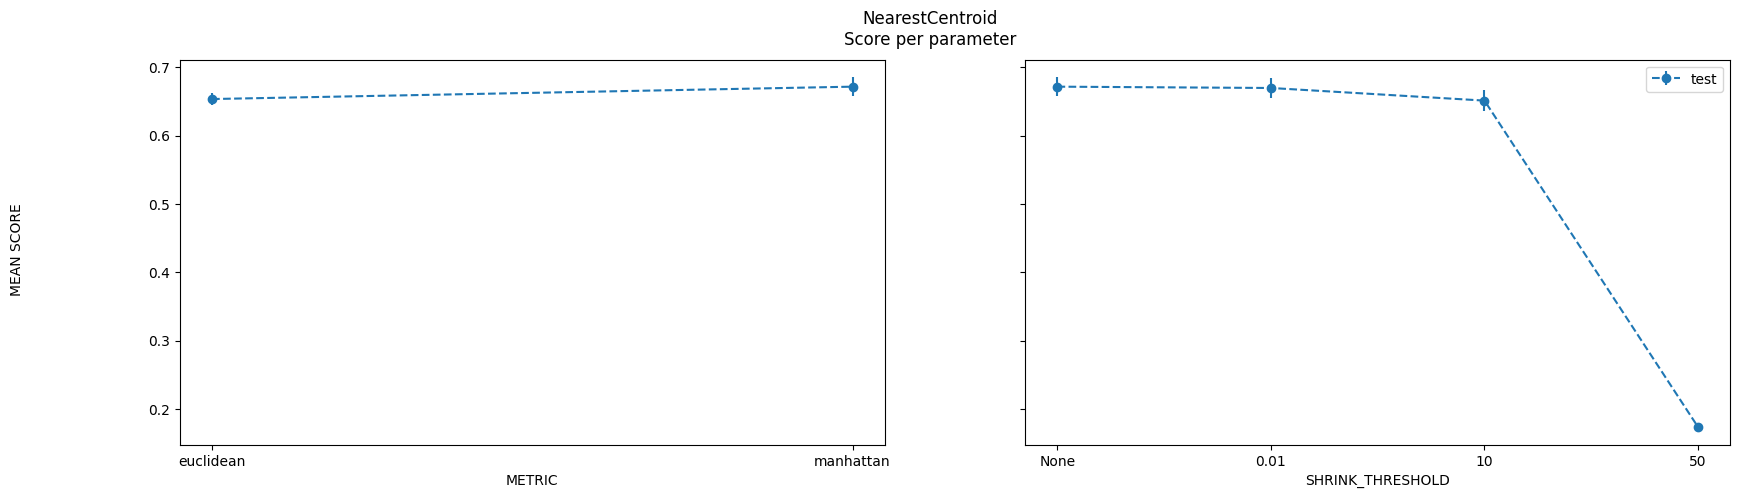

Best params: {'metric': 'manhattan', 'shrink_threshold': None}


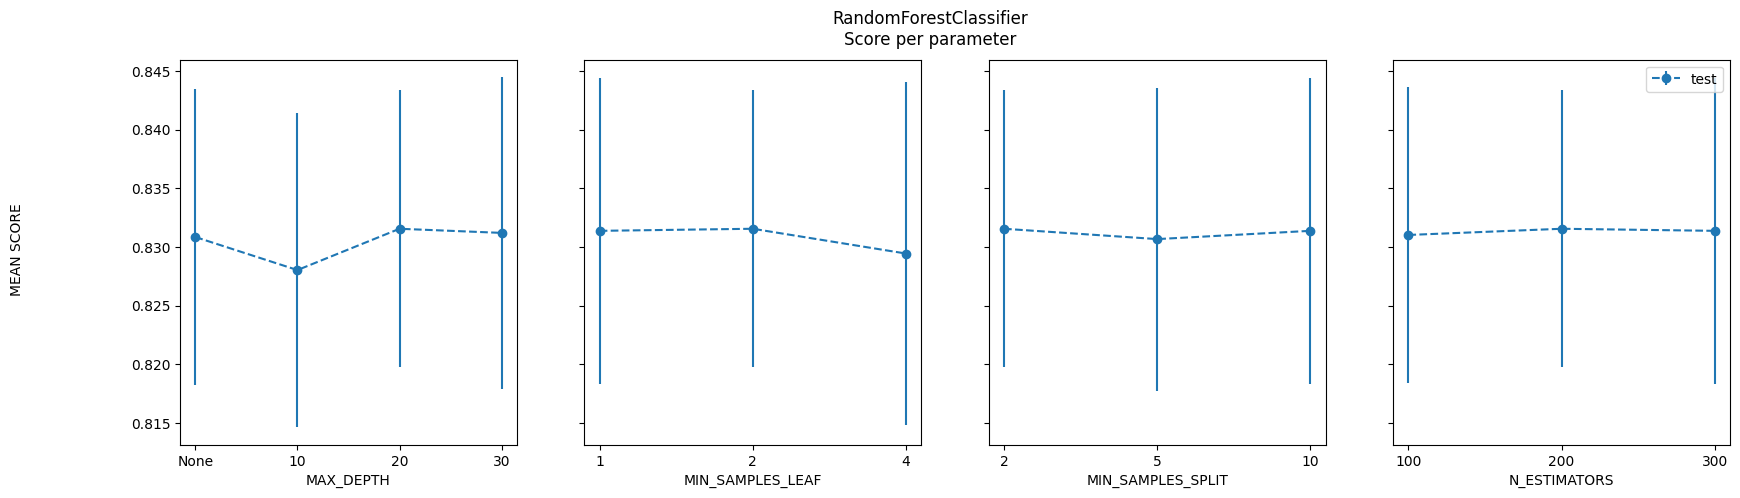

Best params: {'max_depth': 20, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 200}


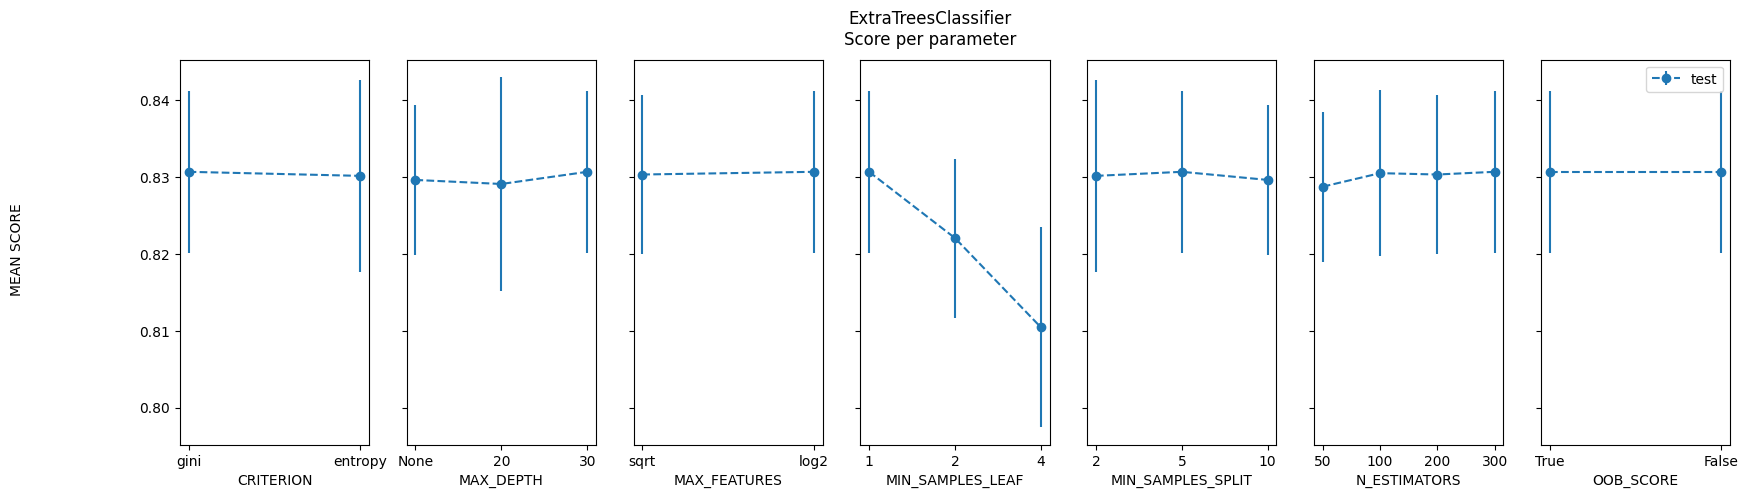

Best params: {'bootstrap': True, 'criterion': 'gini', 'max_depth': 30, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 300, 'oob_score': True}


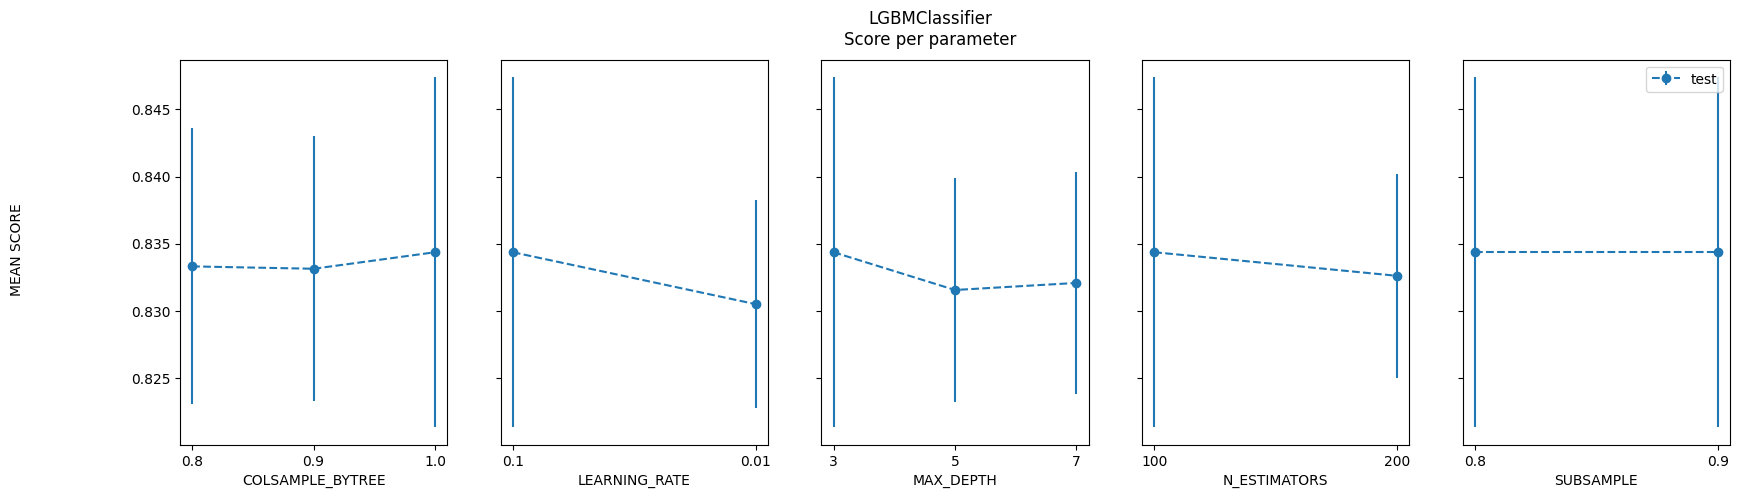

Best params: {'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.8}


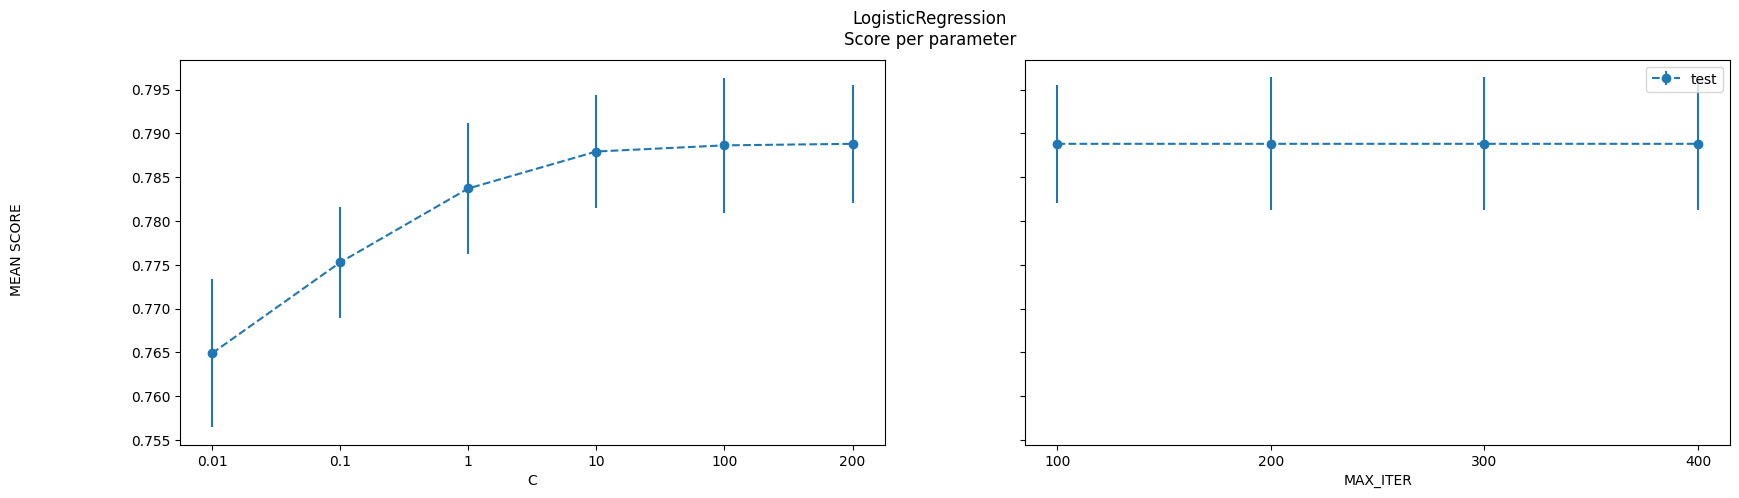

Best params: {'C': 200, 'max_iter': 100, 'penalty': 'l2', 'solver': 'lbfgs'}


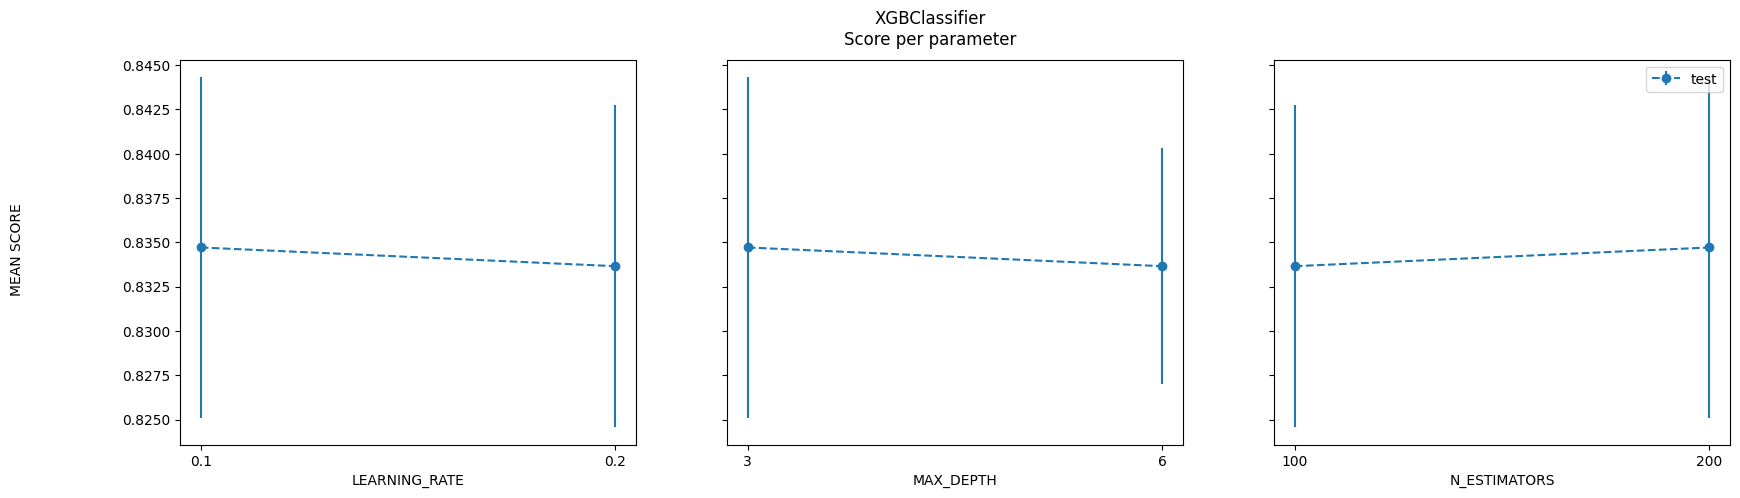

Best params: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200}


In [11]:
models = ['NearestCentroid', 'RandomForestClassifier', 'ExtraTreesClassifier', 'LGBMClassifier', 'LogisticRegression', 'XGBClassifier']
for model_name in models:
    model_result = copy.deepcopy(data_results[model_name])
    plot_search_results(model_result['cv_results'], model_result['best_params'], model_result['param_grid'], model_name)
    print("Best params:", model_result['best_params'])
    print("="*100)

# Analyse des meilleurs résultats

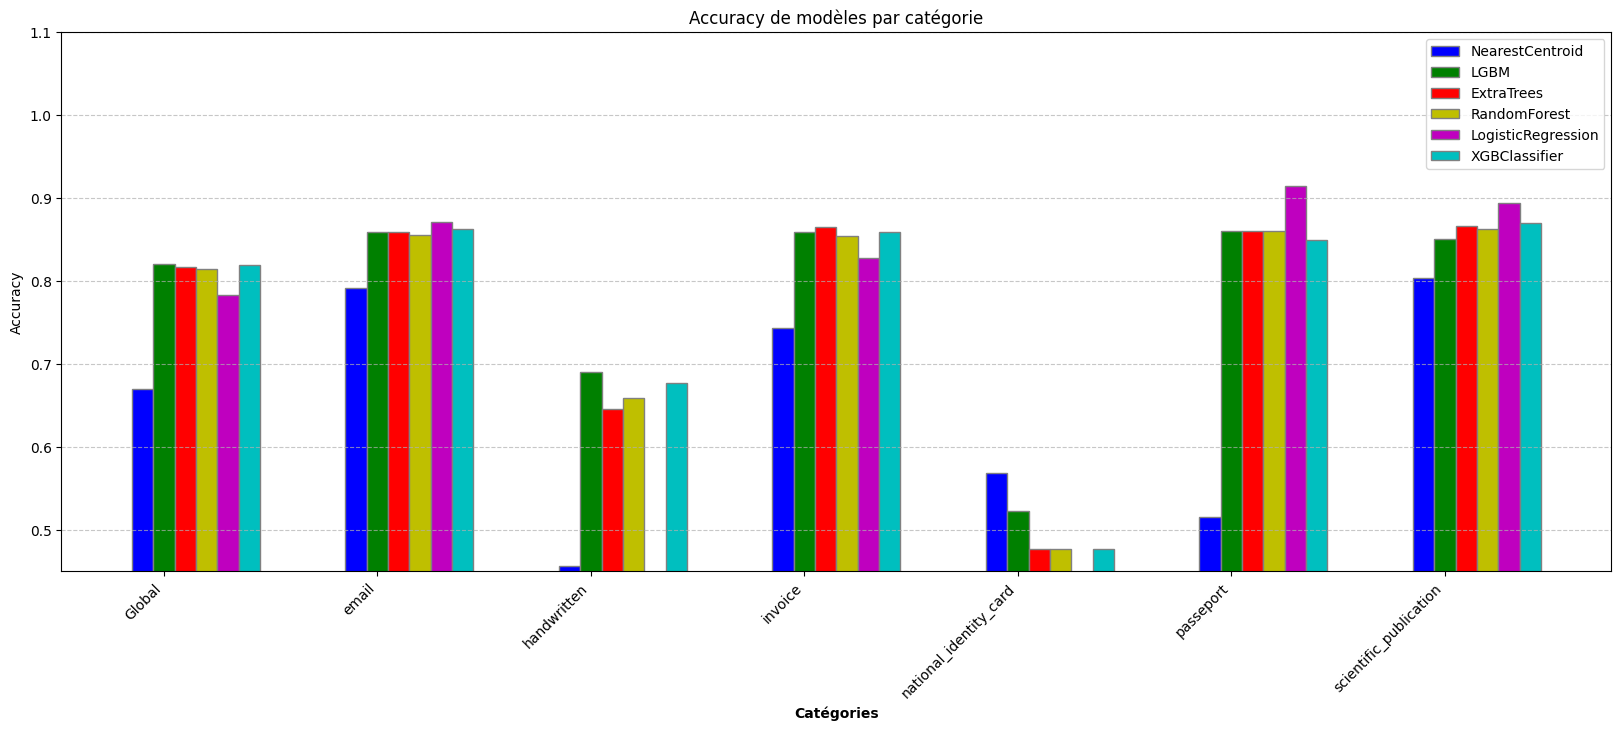

In [12]:
# Labels des catégories
categories = list(data_results['NearestCentroid']['accuracy'].keys())

# Valeurs d'accuracy pour chaque modèle
values_NearestCentroid = list(data_results['NearestCentroid']['accuracy'].values())
values_LGBM = list(data_results['LGBMClassifier']['accuracy'].values())
values_ExtraTrees = list(data_results['ExtraTreesClassifier']['accuracy'].values())
values_RandomForest = list(data_results['RandomForestClassifier']['accuracy'].values())
values_LogisticRegression = list(data_results['LogisticRegression']['accuracy'].values())
values_XGB = list(data_results['XGBClassifier']['accuracy'].values())

# Largeur des barres
bar_width = 0.1

# Positions des barres sur l'axe x
r1 = range(len(categories))
r2 = [x + bar_width for x in r1]
r3 = [x + bar_width for x in r2]
r4 = [x + bar_width for x in r3]
r5 = [x + bar_width for x in r4]
r6 = [x + bar_width for x in r5]

# Création du graphique
plt.figure(figsize=(20, 7))
plt.bar(r1, values_NearestCentroid, color='b', width=bar_width, edgecolor='grey', label='NearestCentroid')
plt.bar(r2, values_LGBM, color='g', width=bar_width, edgecolor='grey', label='LGBM')
plt.bar(r3, values_ExtraTrees, color='r', width=bar_width, edgecolor='grey', label='ExtraTrees')
plt.bar(r4, values_RandomForest, color='y', width=bar_width, edgecolor='grey', label='RandomForest')
plt.bar(r5, values_LogisticRegression, color='m', width=bar_width, edgecolor='grey', label='LogisticRegression')
plt.bar(r6, values_XGB, color='c', width=bar_width, edgecolor='grey', label='XGBClassifier')

plt.xlabel('Catégories', fontweight='bold')
plt.xticks([r + bar_width for r in range(len(categories))], categories)
plt.ylabel('Accuracy')
plt.title('Accuracy de modèles par catégorie')

plt.legend()
plt.ylim(0.45,1.1)
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# VotingClassifier

In [14]:
from sklearn.ensemble import VotingClassifier

estimators = [
    ('LogisticRegression', load('models/words_scaled_LogisticRegression.joblib')),
    ('RandomForest', load('models/words_scaled_RandomForestClassifier.joblib')),
    ('ExtraTrees', load('models/words_scaled_ExtraTreesClassifier.joblib')),
    ('LGBM', load('models/words_scaled_LGBMClassifier.joblib')),
    ('XGB', load('models/words_scaled_XGBClassifier.joblib')),
]

voting_hard = VotingClassifier(estimators, voting='hard', n_jobs=16)
voting_soft = VotingClassifier(estimators, voting='soft', n_jobs=16)

voting_hard.fit(X_train_scaled, y_train)
voting_soft.fit(X_train_scaled, y_train)

VotingClassifier(estimators=[('LogisticRegression',
                              LogisticRegression(C=200, random_state=42)),
                             ('RandomForest',
                              RandomForestClassifier(max_depth=20,
                                                     min_samples_leaf=2,
                                                     n_estimators=200,
                                                     random_state=42)),
                             ('ExtraTrees',
                              ExtraTreesClassifier(bootstrap=True, max_depth=30,
                                                   max_features='log2',
                                                   min_samples_split=5,
                                                   n_estimators=300,
                                                   oob_score=True,
                                                   random_state=42...
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rate=0.1, max_bin=None,
                                            max_cat_threshold=None,
                                            max_cat_to_onehot=None,
                                            max_delta_step=None, max_depth=3,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=200, n_jobs=None,
                                            num_parallel_tree=None,
                                            objective='multi:softprob', ...))],
                 n_jobs=16, voting='soft')

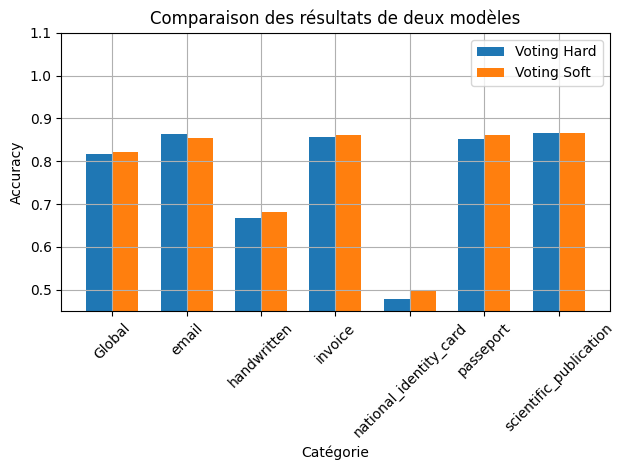

In [16]:
accuracy_voting_hard = calculate_accuracy(voting_hard, X_test_scaled, y_test)
accuracy_voting_soft = calculate_accuracy(voting_soft, X_test_scaled, y_test)


categories = list(accuracy_voting_hard.keys())
accuracy_hard = list(accuracy_voting_hard.values())
accuracy_soft = list(accuracy_voting_soft.values())

x = range(len(categories))
width = 0.35

plt.bar(x, accuracy_hard, width, label='Voting Hard')
plt.bar([i + width for i in x], accuracy_soft, width, label='Voting Soft')

plt.xlabel('Catégorie')
plt.ylabel('Accuracy')
plt.title('Comparaison des résultats de deux modèles')
plt.xticks([i + width/2 for i in x], categories, rotation=45)
plt.legend()
plt.ylim(0.45,1.1)
plt.grid()
plt.tight_layout()
plt.show()

In [17]:
model_vc_name = "words_scaled_VotingClassifier.joblib"
dump(voting_hard, os.path.join('models', model_vc_name))

['models\\words_scaled_VotingClassifier.joblib']

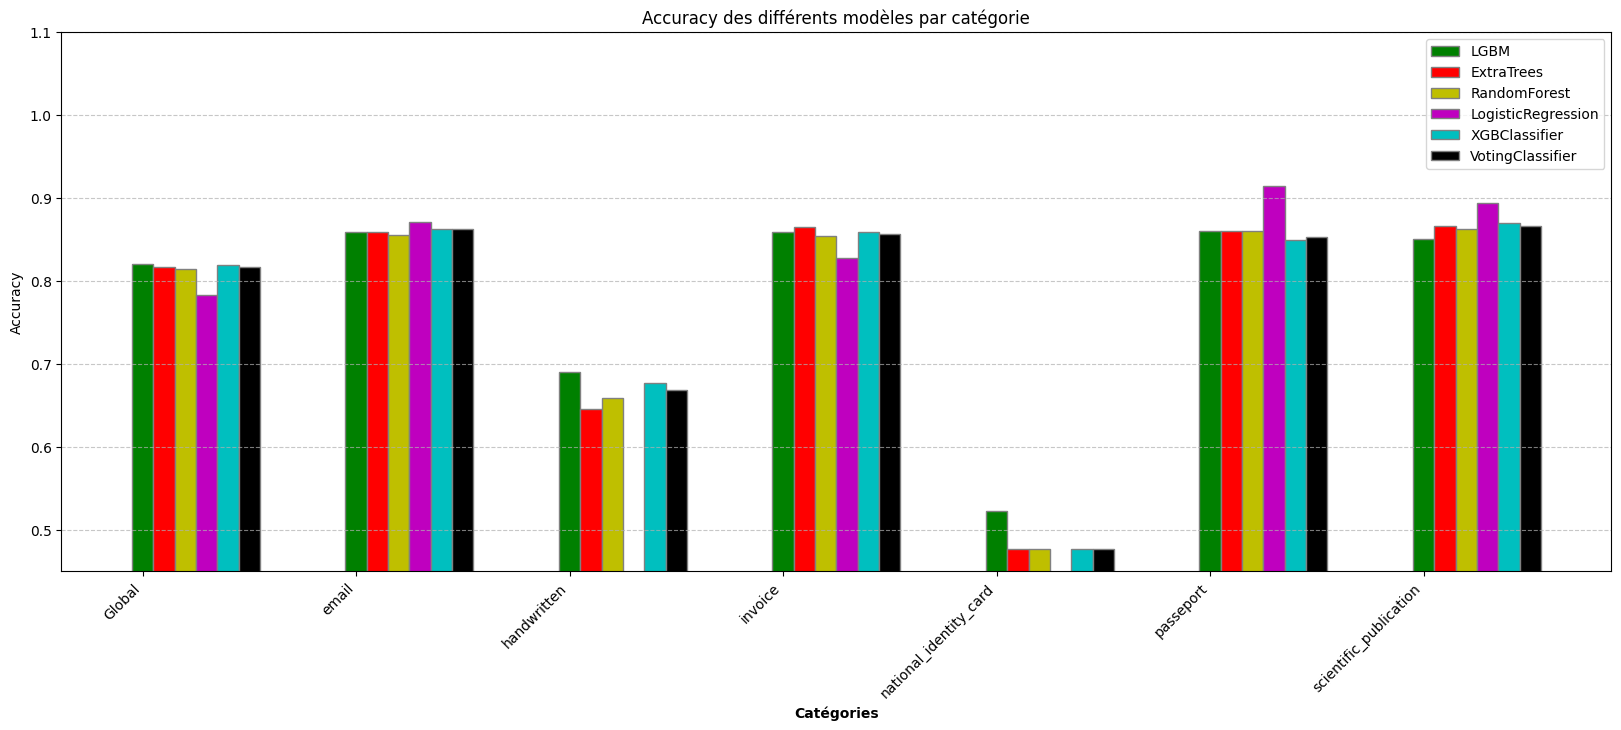

In [18]:
values_voting_hard = list(accuracy_voting_hard.values())

r7 = [x + bar_width for x in r6]

# Création du graphique
plt.figure(figsize=(20, 7))
#plt.bar(r1, values_NearestCentroid, color='b', width=bar_width, edgecolor='grey', label='NearestCentroid')
plt.bar(r2, values_LGBM, color='g', width=bar_width, edgecolor='grey', label='LGBM')
plt.bar(r3, values_ExtraTrees, color='r', width=bar_width, edgecolor='grey', label='ExtraTrees')
plt.bar(r4, values_RandomForest, color='y', width=bar_width, edgecolor='grey', label='RandomForest')
plt.bar(r5, values_LogisticRegression, color='m', width=bar_width, edgecolor='grey', label='LogisticRegression')
plt.bar(r6, values_XGB, color='c', width=bar_width, edgecolor='grey', label='XGBClassifier')
plt.bar(r7, values_voting_hard, color='k', width=bar_width, edgecolor='grey', label='VotingClassifier')

plt.xlabel('Catégories', fontweight='bold')
plt.xticks([r + bar_width for r in range(len(categories))], categories)
plt.ylabel('Accuracy')
plt.title('Accuracy des différents modèles par catégorie')

plt.legend()
plt.ylim(0.45,1.1)
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()